In [1]:
# https://www.kaggle.com/datasets/puneet6060/intel-image-classification

# Step 1: Import Libraries

In [2]:
# Libraries
import torch
from torch.utils.data import DataLoader
from torch.optim import Adam
import torch.nn as nn
from torch.nn import Linear, Conv2d, BatchNorm2d, Dropout2d, AvgPool2d

from torchvision.datasets import ImageFolder
from torchvision.transforms import transforms

import numpy as np
from time import time
from tqdm import tqdm
import matplotlib.pyplot as plt
from PIL import Image 

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Step 2: Data Loader

In [3]:
# Train and Test Root

TRAIN_PATH = "seg_train/seg_train/"
TEST_PATH = "seg_test/seg_test/"

In [4]:
# Create Transformer Object

tfm_obj = transforms.Compose([
    transforms.Resize((128,128)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5],[0.5, 0.5, 0.5])
])

# Create Data Loader
train_loader = DataLoader(ImageFolder(root=TRAIN_PATH, transform=tfm_obj), batch_size = 20, shuffle=True)
test_loader = DataLoader(ImageFolder(root=TEST_PATH, transform=tfm_obj), batch_size = 50, shuffle=True)

# Step 3: Create Model

In [5]:
class CNNIntel(nn.Module):
    def __init__(self, input_features, output_features):
        super(CNNIntel, self).__init__()
        self.ip = input_features
        self.out = output_features
        self.activation = nn.LeakyReLU(inplace=True)
        self.pool = AvgPool2d(kernel_size=(3,3), stride = 1)
        
        self.conv1 = Conv2d(in_channels=self.ip, out_channels=6, kernel_size=(3,3), stride=1, padding=1)
        self.bn1 = BatchNorm2d(num_features=6)
        self.conv2 = Conv2d(in_channels=6, out_channels=12, kernel_size=(3,3), stride=1, padding=1)
        self.bn2 = BatchNorm2d(num_features=12)
        
        self.lin1 = Linear(in_features=12*124*124, out_features=64)
        self.lin2 = Linear(in_features=64, out_features=self.out)
        self.softmax = nn.LogSoftmax(dim=1)
        
    def forward(self,X):
        # Convolution Layer 1
        output = self.conv1(X)
        output = self.pool(output)
        output = self.bn1(output)
        output = self.activation(output)
        # Convolution Layer 2
        output = self.conv2(output)
        output = self.pool(output)
        output = self.bn2(output)
        output = self.activation(output)
        # Flatten Output
        output = output.reshape(-1, 12*124*124)
        # Fully Connected Layers
        output = self.lin1(output)
        output = self.activation(output)
        output = self.lin2(output)
        output = self.softmax(output)
        return output
    
# Instantiate the Model    
model = CNNIntel(input_features=3,output_features=6)
model = model.to(device)

# Step 4: Train and Evaluate the Model

In [8]:
# CONSTANTS
EPOCHS = 10
optimizer = Adam(model.parameters(), lr=0.001, weight_decay=0.0005)
loss_fn = nn.CrossEntropyLoss()
TRAIN_COUNT, TEST_COUNT = len(ImageFolder(TRAIN_PATH)), len(ImageFolder(TEST_PATH))

In [9]:
# TRAIN & TEST MODEL

train_loss_list = []
train_acc_list = []
test_loss_list = []
test_acc_list = []

for epoch in range(EPOCHS):
    start = time()
    
    tr_acc = 0
    tst_acc = 0
    
    model.train()
    
    with tqdm(train_loader, unit="batch") as tepoch:
        for xtrain, ytrain in tepoch:
            xtrain = xtrain.cuda()
            optimizer.zero_grad()
            train_output = model(xtrain)
            train_output = train_output.cpu()
            loss = loss_fn(train_output, ytrain)
            loss.backward()
            optimizer.step()

            ytrain_pred = torch.max(train_output,1).indices
            tr_acc += int(torch.sum(ytrain_pred == ytrain))
    
    model.eval()
    with torch.no_grad():
        for xtest, ytest in test_loader:
            xtest = xtest.cuda()
            test_output = model(xtest)
            test_output = test_output.cpu()
            test_loss = loss_fn(test_output, ytest)
            ytest_pred = torch.max(test_output, 1).indices
            tst_acc += int(torch.sum(ytest_pred == ytest))

    ep_tr_acc = tr_acc / TRAIN_COUNT
    ep_tst_acc = tst_acc / TEST_COUNT

    train_loss_list.append(loss)
    train_acc_list.append(ep_tr_acc)

    test_loss_list.append(test_loss)
    test_acc_list.append(ep_tst_acc)
        
    end = time()
    
    duration = (end-start)/60
    
    print(f"Ep: {epoch}, time_cost: {duration},\n tr_loss: {loss}, tst_loss: {test_loss},\n tr_acc: {ep_tr_acc}, tst_acc: {ep_tst_acc}")

100%|█████████████████████████████████████████████████████████████████████████████| 702/702 [01:38<00:00,  7.12batch/s]


Ep: 0, time_cost: 1.7834228118260702,
 tr_loss: 0.7578233480453491, tst_loss: 0.8955138921737671,
 tr_acc: 0.6013966082371384, tst_acc: 0.6463333333333333


100%|█████████████████████████████████████████████████████████████████████████████| 702/702 [01:09<00:00, 10.14batch/s]


Ep: 1, time_cost: 1.3647009531656902,
 tr_loss: 0.9495207071304321, tst_loss: 1.078446626663208,
 tr_acc: 0.6281174291007553, tst_acc: 0.639


100%|█████████████████████████████████████████████████████████████████████████████| 702/702 [00:55<00:00, 12.76batch/s]


Ep: 2, time_cost: 1.1325293183326721,
 tr_loss: 0.882487952709198, tst_loss: 0.9467880129814148,
 tr_acc: 0.6292575174576029, tst_acc: 0.635


100%|█████████████████████████████████████████████████████████████████████████████| 702/702 [00:55<00:00, 12.63batch/s]


Ep: 3, time_cost: 1.1478907108306884,
 tr_loss: 1.0713090896606445, tst_loss: 1.3134840726852417,
 tr_acc: 0.6443636881858344, tst_acc: 0.652


100%|█████████████████████████████████████████████████████████████████████████████| 702/702 [00:53<00:00, 13.11batch/s]


Ep: 4, time_cost: 1.0679919044176738,
 tr_loss: 1.4818934202194214, tst_loss: 0.9379019141197205,
 tr_acc: 0.6543394613082514, tst_acc: 0.6056666666666667


100%|█████████████████████████████████████████████████████████████████████████████| 702/702 [00:27<00:00, 25.40batch/s]


Ep: 5, time_cost: 0.5538481076558431,
 tr_loss: 1.0340361595153809, tst_loss: 1.0169281959533691,
 tr_acc: 0.6603249251817016, tst_acc: 0.6576666666666666


100%|█████████████████████████████████████████████████████████████████████████████| 702/702 [00:27<00:00, 25.47batch/s]


Ep: 6, time_cost: 0.5549839735031128,
 tr_loss: 0.8378270864486694, tst_loss: 1.054299235343933,
 tr_acc: 0.6703006983041185, tst_acc: 0.6633333333333333


100%|█████████████████████████████████████████████████████████████████████████████| 702/702 [00:27<00:00, 25.71batch/s]


Ep: 7, time_cost: 0.5474833091100056,
 tr_loss: 0.5579690933227539, tst_loss: 0.9100173711776733,
 tr_acc: 0.6692318654695739, tst_acc: 0.6893333333333334


100%|█████████████████████████████████████████████████████████████████████████████| 702/702 [00:28<00:00, 24.78batch/s]


Ep: 8, time_cost: 0.5713573137919108,
 tr_loss: 0.9862345457077026, tst_loss: 0.9444583058357239,
 tr_acc: 0.6782100612797491, tst_acc: 0.655


100%|█████████████████████████████████████████████████████████████████████████████| 702/702 [00:27<00:00, 25.14batch/s]


Ep: 9, time_cost: 0.5638591488202412,
 tr_loss: 1.1301864385604858, tst_loss: 0.9394732117652893,
 tr_acc: 0.6746472851646003, tst_acc: 0.6523333333333333


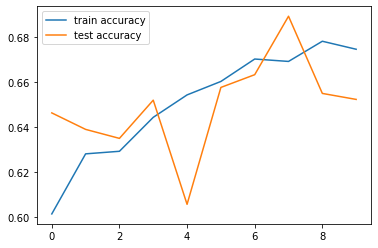

In [11]:
# Train Metrics
# Accuracy

plt.plot(range(EPOCHS),train_acc_list, label="train accuracy")

plt.plot(range(EPOCHS),test_acc_list, label="test accuracy")
plt.legend()

# Model Performance Demonstration

In [22]:
# Index mapping for the dataframe

idx_to_class = {0: 'buildings',
 1: 'forest',
 2: 'glacier',
 3: 'mountain',
 4: 'sea',
 5: 'street'}

In [17]:
sample_image_1 = "seg_pred/seg_pred/10021.jpg"
sample_image_2 = "seg_pred/seg_pred/10101.jpg"
sample_image_3 = "seg_pred/seg_pred/10005.jpg"
sample_image_4 = "seg_pred/seg_pred/11163.jpg"

img_list = [sample_image_1, sample_image_2, sample_image_3, sample_image_4]

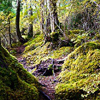

forest


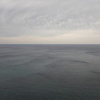

sea


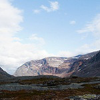

mountain


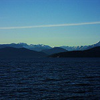

mountain


In [23]:
# Model Performance
for img_path in img_list:
    img = Image.open(img_path)
    display(img.resize((100, 100)))
    img_tensor = tfm_obj(img)
    img_tensor = img_tensor[np.newaxis, :]
    img_tensor = img_tensor.to(device)
    prob = model(img_tensor)
    pred = torch.max(prob, 1).indices
    pred = pred.item()
    print(idx_to_class[pred])
    print("====================================")

---
## Author:
Notebook by Shounak Deshpande<br>
Email: shounak.python@gmail.com